## Практическая работа №4
Необходимо на основе результатов, полученных при выполнении Практической работы №3, расширить полученный семантический анализатор естественного языка для обработки корпуса документов. Используйте нейросети CNN и/или RNN.

In [240]:
import os
import re
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

## Параметры

In [306]:
SONGS_NUM = 100
TOPICS_NUM = 8
DISPLAY_NUM = 10

## Загрузка данных

In [316]:
def load_songs(folder_path="data/texts"):
    documents = []
    titles = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                documents.append(content)
                titles.append(filename.replace('.txt', ''))
    
    return documents, titles

songs, song_titles = load_songs("data/texts")
songs = songs[:SONGS_NUM]
song_titles = song_titles[:SONGS_NUM]

print(f"Загружено {len(songs)} песен")

Загружено 100 песен


### Нормализация
Функция *normalize_text* выполняет нормализацию текстов песен, очищая их от лишних символов, пунктуации и стоп слов, а также приводя все слова к нижнему регистру и их базовой форме с помощью лемматизации. За счет этого тексты получаются унифицироваными и готовыми к дальнейшему векторному представлению и семантическому анализу.

In [308]:
def normalize_text(text):
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = text.lower()
    
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    lemmas = [lemmatizer.lemmatize(w) for w in words if w.isalpha() and w not in stop_words]
    return " ".join(lemmas)

normalized_songs = [normalize_text(song) for song in songs]

print("Песни после нормализации:")
for i in range(min(DISPLAY_NUM, len(normalized_songs))):
    print(f'"{song_titles[i]}": {normalized_songs[i][:30]}...')

Песни после нормализации:
"#1": gon na learn got let thing go ...
"America": feel close feel close like wan...
"Amsterdam": sorry brother sorry let well d...
"Bad Liar": look eye tell see perfect para...
"Battle Cry": star visible darkness fear eve...
"Believer": second thing second tell think...
"Birds": season change life make grow d...
"Bleeding Out": day come lost way around seaso...
"Bones": patience waning entertaining p...
"Boomerang": cause bad lettin go lettin go ...


## Расширить полученный семантический анализатор естественного языка для обработки корпуса документов. Используйте нейросети CNN и/или RNN.

In [309]:
nltk.download('vader_lexicon', quiet=True)

def get_text_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    compound_score = scores["compound"]
    if compound_score >= 0.05:
        return "pos"
    elif compound_score <= -0.05:
        return "neg"
    else:
        return "neu"

labels_dict = {
    "neu": "нейтральную",
    "pos": "положительную", 
    "neg": "отрицательную",
}

print("Тональность песен:")
for i in range(min(DISPLAY_NUM, len(normalized_songs))):
    sentiment = get_text_sentiment(normalized_songs[i])
    print(f"Песня {i+1} ({song_titles[i]}) имеет {labels_dict[sentiment]} тональность")

Тональность песен:
Песня 1 (#1) имеет положительную тональность
Песня 2 (America) имеет положительную тональность
Песня 3 (Amsterdam) имеет положительную тональность
Песня 4 (Bad Liar) имеет отрицательную тональность
Песня 5 (Battle Cry) имеет отрицательную тональность
Песня 6 (Believer) имеет отрицательную тональность
Песня 7 (Birds) имеет положительную тональность
Песня 8 (Bleeding Out) имеет отрицательную тональность
Песня 9 (Bones) имеет положительную тональность
Песня 10 (Boomerang) имеет положительную тональность


### Векторизация TF-IDF

In [310]:
vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=2, 
    max_features=1000,
    stop_words="english",
)
tfidf_model = vectorizer.fit_transform(normalized_songs)
feature_names = vectorizer.get_feature_names_out()
print(f"\n10 признаков из матрицы TF-IDF: {', '.join(feature_names[:10])}")


10 признаков из матрицы TF-IDF: afraid, age, ah, ahead, air, alive, allows, alright, answer, anxious


### LSA анализ

In [311]:
def print_heatmap(matrix, titles):
    display_matrix = matrix[:DISPLAY_NUM, :DISPLAY_NUM]
    display_titles = titles[:DISPLAY_NUM]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        display_matrix,
        xticklabels=display_titles,
        yticklabels=display_titles,
        cmap="YlGnBu",
        annot=True,
        fmt=".2f",
        square=True,
    )
    plt.title("Тепловая карта семантической близости песен (LSA)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

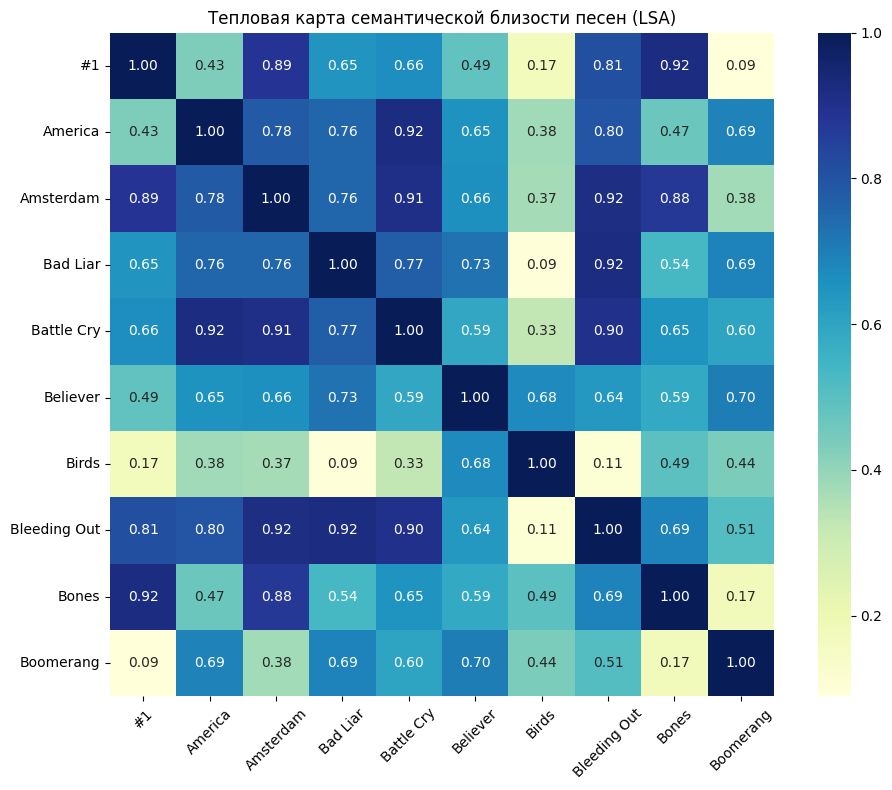

Список самых значимых слов в темах (LSA):
Тема 1: oh, hey, ooh, da, know
Тема 2: da, la, thunder, follow, young
Тема 3: la, hey, gun, okay, love
Тема 4: hey, ooh, da, giving, gun
Тема 5: oh, ready, la, whoa, da
Тема 6: ooh, la, day, fly, night
Тема 7: ah, ooh, yeah, beach, mountain
Тема 8: enemy, everybody, look, want, pray


In [315]:
lsa = TruncatedSVD(n_components=TOPICS_NUM, random_state=0)
lsa_model = lsa.fit_transform(tfidf_model)

similarity_matrix = cosine_similarity(lsa_model)
print_heatmap(similarity_matrix, song_titles)

n_words = 5
print(f"Список самых значимых слов в темах (LSA):")
for i, topic in enumerate(lsa.components_):
    idxs = topic.argsort()[-n_words:][::-1]
    print(f"Тема {i+1}: {', '.join([feature_names[idx] for idx in idxs])}")

### Doc2Vec анализ

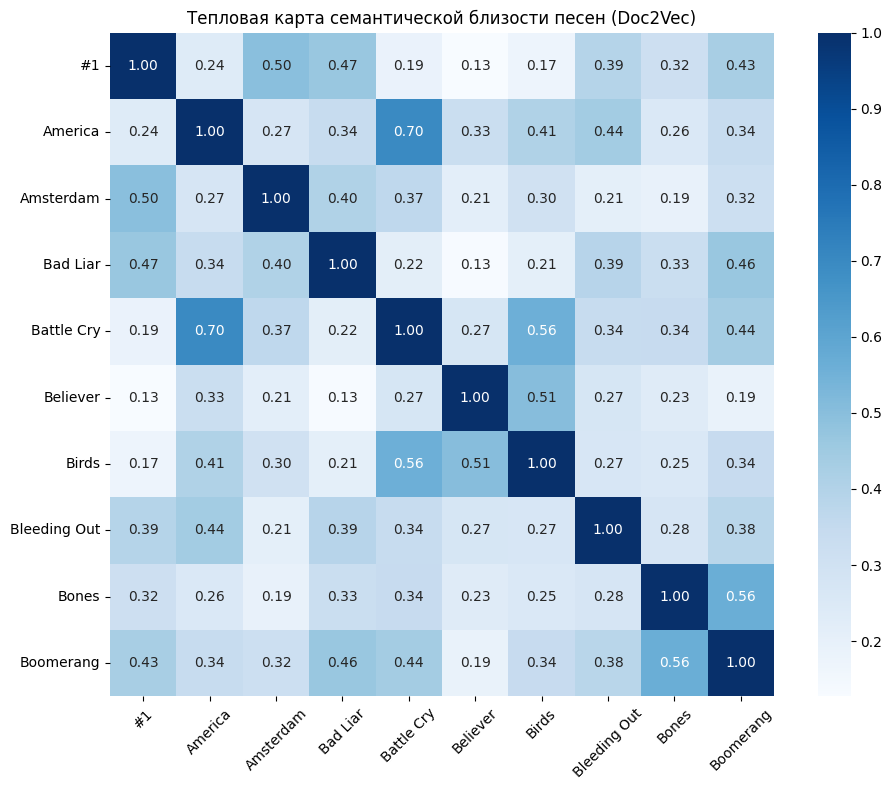

In [313]:
tagged_data = [
    TaggedDocument(words=doc.split(" "), tags=[f"SONG_{i}"])
    for i, doc in enumerate(normalized_songs)
]

doc2vec_model = Doc2Vec(min_count=2, epochs=32, dm=0, workers=4, seed=0)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(
    tagged_data,
    total_examples=doc2vec_model.corpus_count,
    epochs=doc2vec_model.epochs,
)

doc2vec_vectors = np.array([
    doc2vec_model.dv[f"SONG_{i}"] for i in range(len(normalized_songs))
])
doc2vec_similarity = cosine_similarity(doc2vec_vectors)

def print_doc2vec_heatmap(matrix, titles):
    display_matrix = matrix[:DISPLAY_NUM, :DISPLAY_NUM]
    display_titles = titles[:DISPLAY_NUM]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        display_matrix,  
        xticklabels=display_titles,
        yticklabels=display_titles,
        cmap="Blues",
        annot=True,
        fmt=".2f", 
        square=True,
    )
    plt.title("Тепловая карта семантической близости песен (Doc2Vec)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print_doc2vec_heatmap(doc2vec_similarity, song_titles)

### Word2Vec анализ

In [314]:
sentences = [doc.split(" ") for doc in normalized_songs]
word2vec_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1,
    epochs=100,
    seed=0
)

print("\nСемантически похожие слова (Word2Vec):")
if len(word2vec_model.wv.key_to_index) > 0:
    sample_words = list(word2vec_model.wv.key_to_index.keys())[:5]
    for word in sample_words:
        if len(word) > 2:
            try:
                similar_words = word2vec_model.wv.most_similar(word, topn=5)
                print(f"    {word}: {', '.join([s[0] for s in similar_words])}")
            except KeyError:
                print(f"{word}: нет похожих слов")


Семантически похожие слова (Word2Vec):
    hey: paying, west, due, c, bu
    ooh: threw, gate, direction, ragin, opulence


### CNN анализ

In [250]:
MAX_VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 200

normalized_all_songs = normalized_songs
sentiments = [get_text_sentiment(t) for t in normalized_all_songs]

le = LabelEncoder()
y = le.fit_transform(sentiments)
num_classes = len(le.classes_)
y = to_categorical(y, num_classes=num_classes)

print(f"Классы тональности: {le.classes_}")
print(f"Распределение: {np.unique(sentiments, return_counts=True)}")

Классы тональности: ['neg' 'neu' 'pos']
Распределение: (array(['neg', 'neu', 'pos'], dtype='<U3'), array([36,  1, 63]))


In [279]:
# Токенизация подготовка
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(normalized_all_songs)
sequences = tokenizer.texts_to_sequences(normalized_all_songs)
word_index = tokenizer.word_index

X = pad_sequences(
    sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
    truncating="post",
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [280]:
embedding_dim = word2vec_model.vector_size
vocab_size = min(len(word_index) + 1, MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

In [290]:
# Создание CNN
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    input_length=MAX_SEQUENCE_LENGTH
))
model.add(Conv1D(64, 5, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [291]:
# Обучение
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=1,
)

# Оценка
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nТочность определения тональности равна: {test_accuracy:.3f}")

Epoch 1/10


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3833 - loss: 1.2233 - val_accuracy: 0.7000 - val_loss: 0.6383
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6000 - loss: 0.9318 - val_accuracy: 0.6750 - val_loss: 0.5856
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7333 - loss: 0.6257 - val_accuracy: 0.5000 - val_loss: 0.7124
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.6855 - val_accuracy: 0.6750 - val_loss: 0.5666
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8667 - loss: 0.4488 - val_accuracy: 0.7500 - val_loss: 0.6081
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8333 - loss: 0.4439 - val_accuracy: 0.7750 - val_loss: 0.5876
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8833 - loss: 0.3507 - val_accuracy: 0.6500 - val_loss: 0.5736
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9833 - loss: 0.2687 - val_accuracy: 0.8250 - val_loss: 0.5827
Epoch 9/10
